# Network analysis by Evgeny Guzeev

In [ ]:
#pip install cdlib --user

**Целью работы** является анализ пользователей при их представлении в виде графа
Для реализации данной цели необходимо решить ряд задач, а именно:

1. Спарсить данные (`user_id`). Данные использовать будем по уже собранным университетам. Специальность "Теплоэнергетика"
2. Собранные данные преобразуем в граф
3. Проиллистрируем графическое представление графа
4. Рассчитаем для каждого пользователя степени, меры центральности, коэффицент кластеризации
5. Разобьем граф на сообщества методом случайного блуждания `walktrap`
6. Посчитаем метрики при разбиении на сообщества

In [ ]:
# Импортируем нужные библиотеки
import vk
import vk_api
import requests
import json
import time
import datetime
import csv
import pandas as pd

In [ ]:
# Библиотеки для работы с сетями
import networkx as nx
# Библиотеки для работы с сообществами
from cdlib import viz
from cdlib import evaluation
from cdlib import algorithms
import random
import networkx.algorithms.community
import matplotlib.pyplot as plt

In [ ]:
# Загрузим данные по теплоэнергетике
df_tes = pd.read_excel('tesiaes.xlsx')
name_teplo = 'Данные пользователей по специальности теплоэнергетика'
df_tes

,Name_univer,university,university_faculty,university_chair,city_id
0,МПУ,1187912,2218667,2039208,1
1,РОСНОУ,336,2245483,2188269,1
2,СФУ,1170190,2263535,1849542,73
3,МЭИ,304,797933,2045746,1
4,ИГЭУ Иваново,499,185680,2056551,55
5,ТПУ,853,2098460,2031451,144
6,УРФУ,477,2231275,2101239,49
7,КГЭИ КАЗАНЬ,530,16938,2061713,60
8,САМГТУ,782,2994,2045060,123
9,КузГТУ,550,2151767,2057938,64


In [ ]:
def search_users1(access_token, year, df_university):  # Функция формирования базы участников сообщества в виде списка

    ''' В качестве аргумента функции будет подаваться:
    массив года выпуска из школы и id университета'''
    user_infor_list = []
    for grad_year in year:
        for i in range(len(df_university)):
            first = vk_api.users.search(access_token=access_token,
                                    university= df_university['university'][i],
                                    university_faculty = df_university['university_faculty'][i],
                                    university_chair = df_university['university_chair'][i],
                                    university_year = grad_year,
                                    v=5.131,
                                    count=1000)
            user_infor_list.extend(first['items'])

            user_list = []
            for i in range(len(user_infor_list)):
                user_list.append(user_infor_list[i])                 # Получили JSON

    df_infor = pd.DataFrame(user_list)                           # Создаем датафрейм из JSON

    df_infor = df_infor.query('is_closed == False')               # Фильтруем по открытости страниц

    df_no_duplicates = df_infor.drop_duplicates('id', keep='last') # убираем дубликаты из ДФ и записываем в новый ДФ

    df_no_duplicates.reset_index(inplace=True)                      # сбрасываем индексацию для беребора в цикле

    series_year = df_no_duplicates['id']                           # получаем серию выпускников с 18 года по 21 год


    return series_year


In [ ]:
year = [n for n in range(2008,2023)]
tesaes_year_series1 = search_users1(access_token, year, df_tes)

Парсинг пользователей уже выполнен воспользуемся готовым списком пользователей по `теплоэнергетике`

In [ ]:
tesaes_year_series1.to_csv('user_id_tes_aes140423.txt', index=False)
tesaes_year_series = pd.read_csv('user_id_tes_aes140423.txt')
tesaes_year_series

,id
0,385756153
1,716637266
2,381438825
3,563520618
4,531550207
...,...
796,57439472
797,6220109
798,31455284
799,230885047


### На основе серии выпускников по теплоэнергетике создаем пустую матрицу смежности, пишем функцию для заполнения матрицы смежности

In [ ]:
def friends_adjacency_matrix(access_token, series):
    index = []
    columns = []
    for i in series:
        index.append(i)
        columns.append(i)
    df_matrix = pd.DataFrame(index=index, columns=columns)
    df_matrix = df_matrix.fillna(0)


    # Если друзья заполняем 1 иначе 0
    for i, user_id in enumerate(series):
        friends_get = vk_api.friends.get(access_token=access_token,
                                   user_id= user_id)
        for k in range(len(series)):
            if series[k] in friends_get['items']:
                df_matrix.iloc[k,i] = 1
            else:
                df_matrix.iloc[k,i] = 0
    return df_matrix








In [ ]:
# Создаем матрицу смежности. Ребро это дружба между пользователями
series2 = tesaes_year_series['id']
tes_matrix2 = friends_adjacency_matrix(access_token, series2)

In [ ]:
tes_matrix2

,385756153,716637266,381438825,563520618,531550207,594410619,548947324,741356475,696116873,586398221,...,540161968,26145889,151015887,208572355,28400506,57439472,6220109,31455284,230885047,224588832
385756153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
716637266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
381438825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
563520618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
531550207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57439472,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
6220109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31455284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230885047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Делаем сохранение на всякий случай
tes_matrix2.to_csv('matr_adj_tes.csv')


In [ ]:
tes_matrix3 = pd.read_csv('matr_adj_tes.csv', index_col=0)
tes_matrix3

,385756153,716637266,381438825,563520618,531550207,594410619,548947324,741356475,696116873,586398221,...,540161968,26145889,151015887,208572355,28400506,57439472,6220109,31455284,230885047,224588832
385756153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
716637266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
381438825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
563520618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
531550207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57439472,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
6220109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31455284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230885047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Сделаем одинаковые типы индексов. Если загрузить c csv то индексы будут числовые, а названия колонок строка.
# Это не дает создать граф из матрицы сежности
# Поэтому типы необходимо выровнять
tes_matrix3.columns = tes_matrix3.index

### Создаем Граф из матрицы смежности

In [ ]:
# Создаем граф
G = nx.from_pandas_adjacency(tes_matrix3)

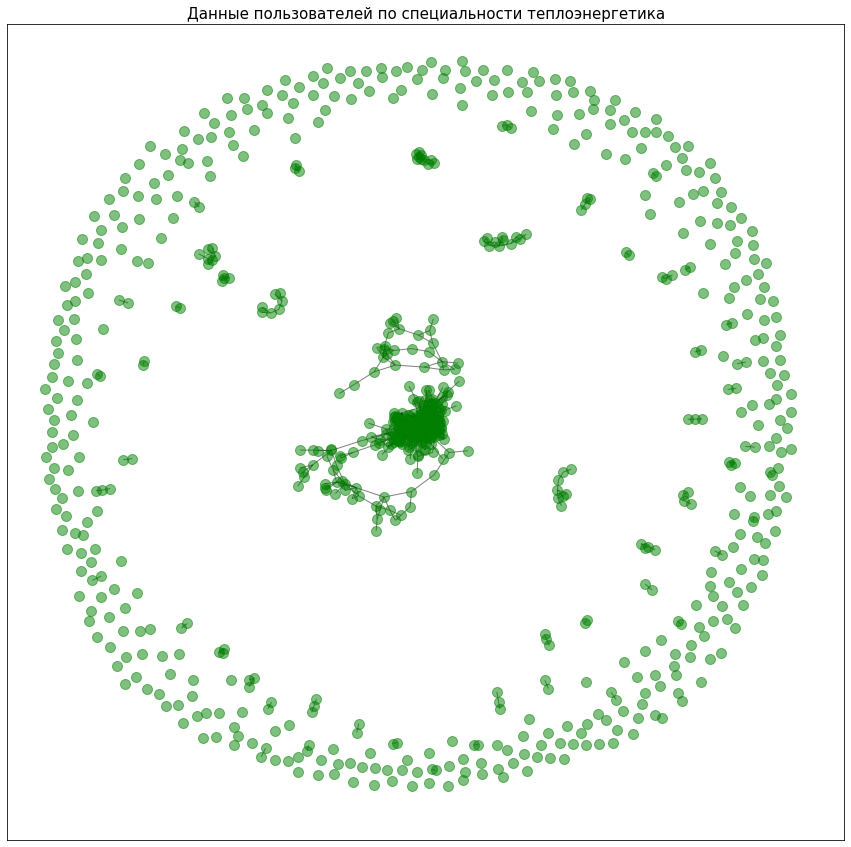

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, with_labels=False, alpha=0.5, node_size=100, node_color='green')
plt.title(name_teplo,fontsize =15)
plt.show()

In [ ]:
def graph_analys(G):

    nodes = G.nodes()
    degree = G.degree()
    for i in sorted(G.nodes()):
        G.nodes[i]['degree'] = G.degree(i)

    #извлекаем вершины из графа
    nodes_data = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=[i[0] for i in G.nodes(data=True)])
    #nodes_data = nodes_data.sort_index(by='Degree',ascending= False)
    nodes_data.index.names=['id']
    nodes_data.reset_index(level=0, inplace=True)


    # Центральность по посредничеству (betweenness centrality)
    bet_cen = nx.betweenness_centrality(G)
    df_bet_cen = pd.DataFrame.from_dict(bet_cen, orient='index')
    df_bet_cen.columns = ['betweenness_centrality']
    df_bet_cen.index.names = ['id']
    df_bet_cen.reset_index(level=0, inplace=True)
    analyse= pd.merge(nodes_data,df_bet_cen, on = ['id'])


    # Коэффиицент кластеризации
    clust_coefficients = nx.clustering(G)
    df_clust = pd.DataFrame.from_dict(clust_coefficients, orient='index')
    df_clust.columns = ['clust_coefficient']
    df_clust.index.names = ['id']
    df_clust.reset_index(level=0, inplace=True)
    analyse= pd.merge(analyse, df_clust, on = ['id'])


    # Центральность по близости (closeness centrality)
    clo_cen = nx.closeness_centrality(G)
    df_clo = pd.DataFrame.from_dict(clo_cen, orient='index')
    df_clo.columns = ['closeness_centrality']
    df_clo.index.names = ['id']
    df_clo.reset_index(level=0, inplace=True)
    analyse= pd.merge(analyse, df_clo, on = ['id'])


    # Центральность по собственному вектору (eigenvector centrality
    #eig_cen = nx.eigenvector_centrality(G)
    #eig_cen = nx.katz_centrality(G)
    eig_cen = nx.eigenvector_centrality_numpy(G)
    df_eig = pd.DataFrame.from_dict(eig_cen, orient='index')
    df_eig.columns = ['eigenvector_centrality']
    df_eig.index.names = ['id']
    df_eig.reset_index(level=0, inplace=True)

    # соединяем все результаты в один датафрейм
    analyse= pd.merge(analyse, df_eig, on = ['id'])

    return analyse

In [ ]:
analyse_teplo = graph_analys(G)
analyse_teplo

,id,degree,betweenness_centrality,clust_coefficient,closeness_centrality,eigenvector_centrality
0,385756153,0,0.000000,0.000000,0.000000,-3.788199e-19
1,716637266,0,0.000000,0.000000,0.000000,-1.245229e-19
2,381438825,0,0.000000,0.000000,0.000000,3.134187e-20
3,563520618,0,0.000000,0.000000,0.000000,4.030871e-19
4,531550207,0,0.000000,0.000000,0.000000,6.974012e-19
...,...,...,...,...,...,...
796,57439472,3,0.000119,0.333333,0.005886,-2.236146e-18
797,6220109,1,0.000000,0.000000,0.001667,-3.953406e-18
798,31455284,8,0.000364,0.607143,0.088598,1.552982e-02
799,230885047,3,0.000670,0.000000,0.083224,7.852781e-03


### Делаем анализ полученных данных

In [ ]:
analyse_teplo.describe()

,id,size,Degree,degree,betweenness_centrality,clust_coefficient,closeness_centrality,eigenvector_centrality
count,8.010000e+02,801.0,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02
mean,1.958491e+08,10.0,3.198502,3.198502,0.000164,0.172374,0.022387,1.149699e-02
std,2.082423e+08,0.0,5.816296,5.816296,0.000654,0.294419,0.036974,3.343133e-02
min,2.201000e+03,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.917817e-17
25%,3.139127e+07,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,-6.979398e-19
50%,1.120892e+08,10.0,1.000000,1.000000,0.000000,0.000000,0.001250,8.436759e-19
75%,3.095814e+08,10.0,3.000000,3.000000,0.000031,0.333333,0.011322,1.207065e-17
max,7.939581e+08,10.0,42.000000,42.000000,0.012944,1.000000,0.124404,2.804336e-01


### Гистограмма распределения полученных данных

Text(0.5, 1.0, 'Гистограммы распределения степени, мер центральности и коэффицента кластеризации')

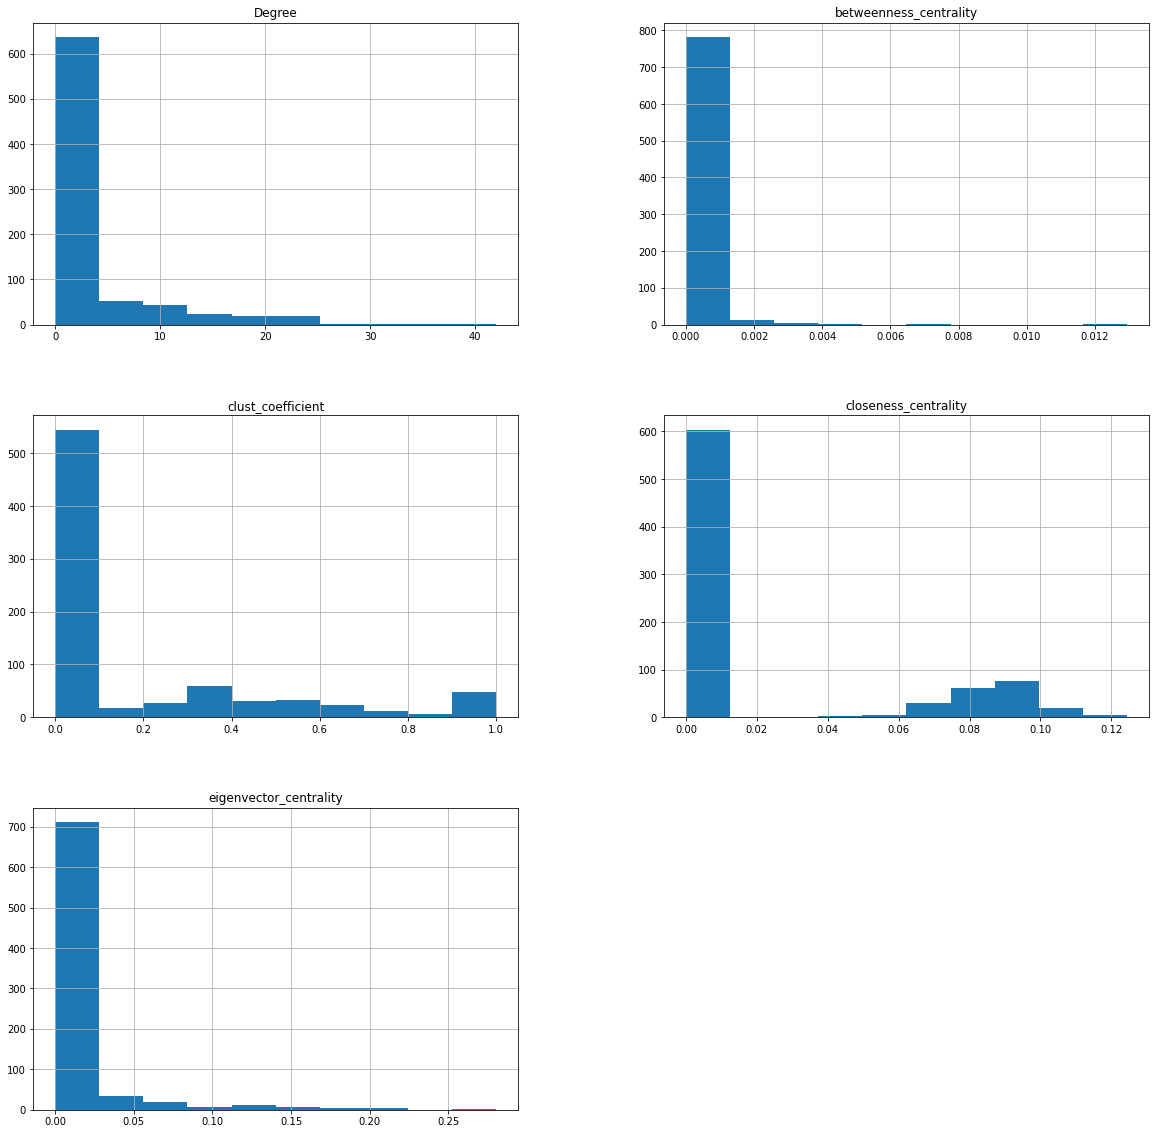

In [ ]:
analyse[['Degree', 'betweenness_centrality', 'clust_coefficient',
       'closeness_centrality', 'eigenvector_centrality']].hist()

plt.title('Гистограммы распределения степени, мер центральности и коэффицента кластеризации')

# Выявление сообществ

Напишем функцию по выявлению сообществ. Алгоритмов выявления сообществ достаточно много. В данном случае будет использоваться `walktrap`.
После разбиения на сообщества будут посчитаны основные метрики

In [ ]:
def com_metrics(g):

    # Алгоритмы выявления сообществ
    com_walktrap = algorithms.walktrap(g)


    community = [com_walktrap]

    # Создаем текстовый список алгоритмов комьюнити

    community_list = ['com_walktrap']

    # modularity
    modularity = evaluation.newman_girvan_modularity(g, com_walktrap)[2]


    # conductance


    conductance = evaluation.conductance(g, com_walktrap)[2]

    # expansion

    expansion = evaluation.expansion(g, com_walktrap)[2]

    #comm_transitivity
    transitivity = evaluation.avg_transitivity(g, com_walktrap)[2]




    data = {'Metrics' : [modularity, conductance, expansion, transitivity, len(com_walktrap.communities)]}

    index = ['Modularity', 'Conductance', 'Expansion', 'Transitivity', 'Number_Community']

    df_metrics = pd.DataFrame(data, index=index)

    return df_metrics

In [ ]:
# Считаем метрики
df_metr = com_metrics(G)
df_metr

,Metrics
Modularity,0.572493
Conductance,0.083556
Expansion,0.247618
Transitivity,0.051117
Number_Community,505.000000


## Графическое представление

Text(0.5, 1.0, 'Разбиение на сообщества пользователей по специальности "Теплоэнергетика"')

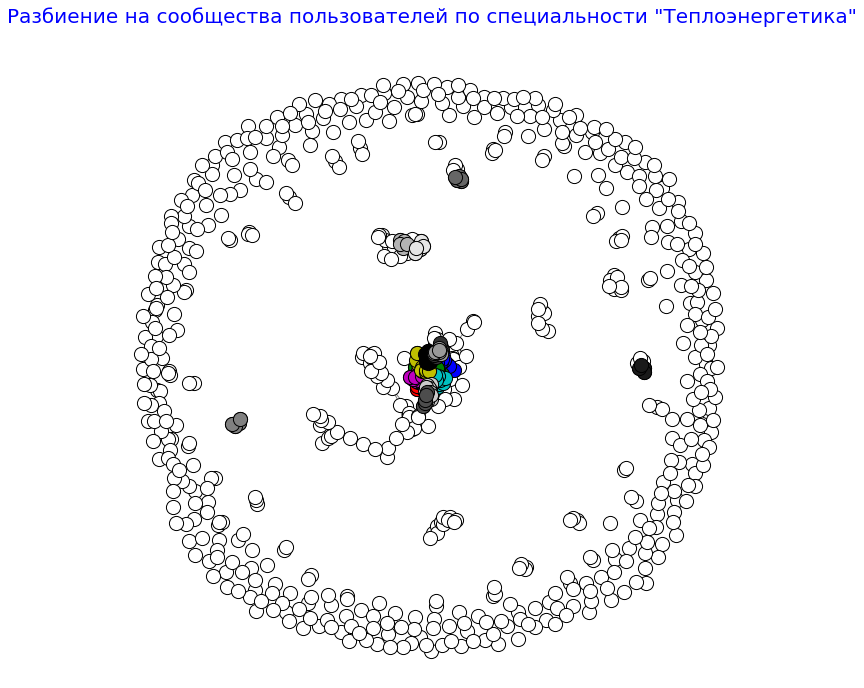

In [ ]:
random.seed(41)
com_title = 'Разбиение на сообщества пользователей по специальности "Теплоэнергетика"'

viz.plot_network_clusters(G, algorithms.walktrap(G), figsize=(12,12))
plt.title(com_title,fontsize=20, color='blue')

### Для быстрого анализа серии пользователей по одной специальности опишем шаги в общем виде

In [ ]:
# Напишем последовательный алгоритм сетевого анализа для следующих данных
# Загрузим данные по какой либо специальности из университетов
df_spec = pd.read_excel('tesiaes.xlsx')
# Зададим имя специальности
name_specialty = 'specialty'

# Спарсим пользователей по этим университетам. Зададим года выпуска
year = [n for n in range(2008,2023)]
spec_series1 = search_users1(access_token, year, df_spec)

# На всякий случай сохраним данные. Так как социальная сеть среда динамичная, возможно
# на другой день одни пользователи сделают страницу приватной другие откроют страницы
spec_series1.to_csv('spec_new.txt', index=False)
# new_spec_series = pd.read_csv('spec_new.txt')


# Создаем матрицу смежности, используя функцию friends_adjacency_matrix
series_new_spec = tesaes_year_series['id']
new_spec_matrix2 = friends_adjacency_matrix(access_token, new_spec_series)

# Сохраняем матрицу смежности
# Делаем сохранение на всякий случай
new_spec_matrix2.to_csv('new_spec_matrix2.csv')

# ******************ВАЖНО************************************************

# В случае загрузки сохраненной матрицы
tes_matrix_new_spec = pd.read_csv('new_spec_matrix2.csv', index_col=0)
# Сделаем одинаковые типы индексов. Если загрузить c csv то индексы будут числовые, а названия колонок строка.
# Это не дает создать граф из матрицы сежности
# Поэтому типы необходимо выровнять
tes_matrix_new_spec.columns = tes_matrix_new_spec.index

# Создаем граф
G = nx.from_pandas_adjacency(tes_matrix_new_spec)

# Анализируем полученный граф
analyse_new_spec = graph_analys(G)


In [ ]:
# Смотрим общие статистики полученных данных метрик
analyse_new_spec.describe()

In [ ]:
# Делаем графическое представление графа
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, with_labels=False, alpha=0.5, node_size=100, node_color='green')
plt.title(name_teplo,fontsize =15)
plt.show()

In [ ]:
# Строим гистограммы данных из анализа графа
analyse[['Degree', 'betweenness_centrality', 'clust_coefficient',
       'closeness_centrality', 'eigenvector_centrality']].hist()

plt.title('Гистограммы распределения степени, мер центральности и коэффицента кластеризации')

In [ ]:
# Выявляем сообщества и определяем метрики качества сообществ

# Считаем метрики
df_new_spec = com_metrics(G)
df_new_spec